# Covid 19 Analysis

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 3) Prediction and Regression
#### 3.1) Random Forest
- - -

In [5]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Long,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered
0,Afghanistan,0.683333,0.680556,2020-01-22,0,0.000000,0,0,0.0
1,Albania,0.728629,0.556023,2020-01-22,0,0.000000,0,0,0.0
2,Algeria,0.655744,0.504610,2020-01-22,0,0.000000,0,0,0.0
3,Andorra,0.736146,0.504227,2020-01-22,0,0.000000,0,0,0.0
4,Angola,0.437763,0.549650,2020-01-22,0,0.000000,0,0,0.0
...,...,...,...,...,...,...,...,...,...
22679,West Bank and Gaza,0.677512,0.597870,2020-05-07,106,0.990654,375,2,176.0
22680,Western Sahara,0.634531,0.464206,2020-05-07,106,0.990654,6,0,5.0
22681,Yemen,0.586404,0.634768,2020-05-07,106,0.990654,25,5,1.0
22682,Zambia,0.414352,0.578565,2020-05-07,106,0.990654,153,4,103.0


In [12]:
# define helper functions
def get_coords_for_country(country):
    country_row = df.loc[df["Country/Region"] == country]
    return country_row["Lat"].unique()[0], country_row["Long"].unique()[0]

get_coords_for_country("Afghanistan")

(0.683333, 0.680556)

In [16]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[0.683333, 0.680556, 0.      ],
       [0.728629, 0.556023, 0.      ],
       [0.655744, 0.50461 , 0.      ],
       ...,
       [0.586404, 0.634768, 0.990654],
       [0.414352, 0.578565, 0.990654],
       [0.388889, 0.583333, 0.990654]])

#### 3.1.1) Regression for Confirmed Cases
- - -

In [34]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([  0,   0,   0, ...,  25, 153,  34])

In [35]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=False)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [36]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
grid_search.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 35.6min finished


Best score: -0.027460416814636585
Best parameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 6693.602535623926
MSE: 1730113369.0915024


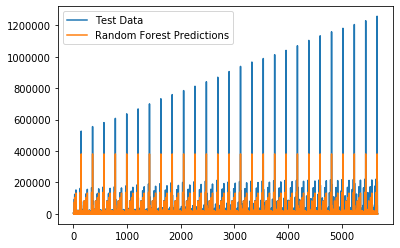

In [38]:
rf_estimator = grid_search.best_estimator_
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(rf_estimator_pred)
plt.legend(['Test Data', 'Random Forest Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))

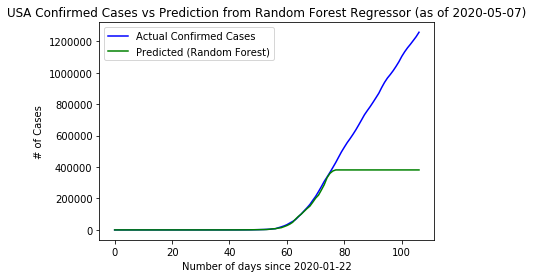

In [52]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

In [1]:
# fazer modelo com Lat e Long